<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ot_2d_rotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* study how Wasserstein distance depends on molecular orientation in 2D

# Resources
* Rao, R., Moscovich, A., & Singer, A. (2020). Wasserstein K-Means for Clustering Tomographic Projections, (2016), 1–11.

# Setup

In [20]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')
import numba
import pandas as pd


In [82]:
!pip install pot
import ot

     |████████████████████████████████| 430kB 5.8MB/s 


# Rotation of eliptical ($\sigma_{yx} \neq 0$) Gaussians

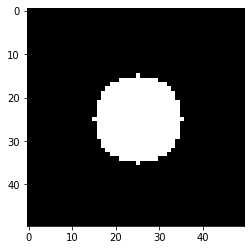

In [70]:
def create_circular_mask(N, radius=None, center=None):
  # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    h,w = N,N
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

doplt(create_circular_mask(50,10))

In [55]:
x, y = np.mgrid[-1:1:.025, -1:1:.025]
pos = np.dstack((x, y))
pos.shape # grid of 200x200 xy coordinates between -1 and 1

(80, 80, 2)

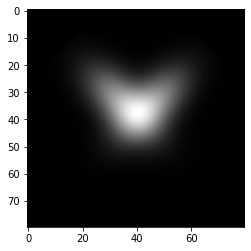

In [77]:
mu=1
rv = multivariate_normal(mean=[0,0], cov=np.array([[2.0, 0], [0, 0.5]]))
g1 = rv.pdf(5*pos+ np.array([mu,0]))
g2 = rv.pdf(5*pos+ np.array([-mu,-0]))
g1_rot = rotate(g1 ,angle=45,reshape=False)
g2_rot = rotate(g1,angle=-45,reshape=False)
I_2d = g1_rot+g2_rot
N=I_2d.shape[0]
mask = create_circular_mask(N,radius=N/2.1)
I_2d[~mask] = 0
doplt(I_2d)

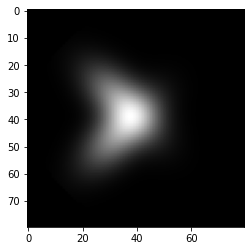

In [78]:
I1 = rotate(I_2d,angle=+90,reshape=False)
doplt(I1)


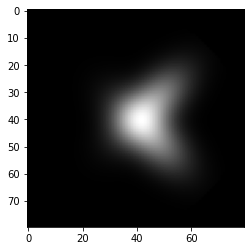

In [135]:
I2 = rotate(I_2d,angle=-90,reshape=False)
doplt(I2)

# Wasserstein vs L2 distance at different rotations

## Cost

In [165]:
@numba.jit
def make_C_from_pos(pos_flat):
  N2 = pos_flat.shape[0]
  C = np.empty((N2,N2))
  np.fill_diagonal(C,0)
  for i in range(C.shape[0]):
    for j in range(i,C.shape[1]):
      C[i,j] = np.sqrt(((pos_flat[i] - pos_flat[j])**2).sum())
      C[j,i] = C[i,j]

  return(C)

In [171]:
%%time
C = make_C_from_pos(pos[mask])
C /= C.max()


CPU times: user 1.57 s, sys: 1.89 ms, total: 1.57 s
Wall time: 1.58 s


In [172]:
C.shape

(4569, 4569)

In [177]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
W = np.zeros(num_angles)

for angle_idx, angle in enumerate(angles):
  I1 = rotate(I_2d,angle=angle/2,reshape=False)
  I2 = rotate(I_2d,angle=-angle/2,reshape=False)
  I1_flat = I1[mask]
  I1_flat /= I1_flat.sum()
  I2_flat = I2[mask]
  I2_flat /= I2_flat.sum()
  W[angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1)

Text(0, 0.5, 'W distance')

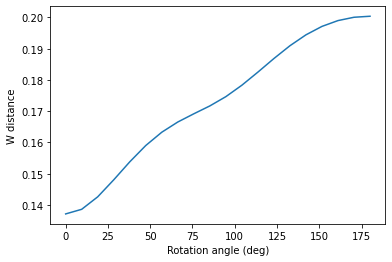

In [181]:
sr = pd.Series(W)
sr.index = angles
ax = sr.plot()
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

We see that the W distance is increasing (monotonically) as the angle does. This makes sense. 

Let's see how things change where there is some noise.

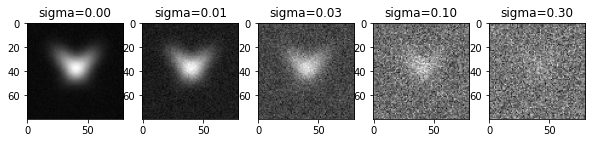

In [217]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
sigmas = [0.003,.01, 0.03,0.1,0.3]
#W = np.zeros((len(sigmas),num_angles))
L2 = np.zeros_like(W)
fig, axes = plt.subplots(ncols=len(sigmas),figsize=(10,10))

for sigma_idx, sigma in enumerate(sigmas):
  noise = np.random.normal(loc=0*I_2d,scale=sigma)
  axes[sigma_idx].imshow(I_2d+noise,cmap='gray')
  axes[sigma_idx].set_title('sigma=%.2f'%sigma)
  for angle_idx, angle in enumerate(angles):
    #print(sigma,angle)
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    #W[sigma_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1)
    L2[sigma_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


In [239]:
def rownorm_01(arr2d):
  arr2d -= arr2d.min(1).reshape(-1,1)
  arr2d /= arr2d.max(1).reshape(-1,1)
  return(arr2d)

L2_01 = rownorm_01(L2.copy())

Text(0, 0.5, 'L2 distance')

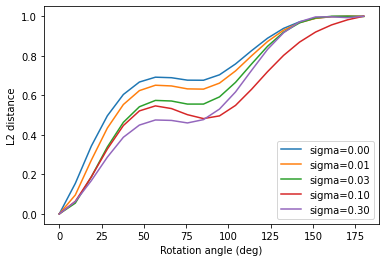

In [238]:
for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(L2_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('L2 distance')

Text(0, 0.5, 'W distance')

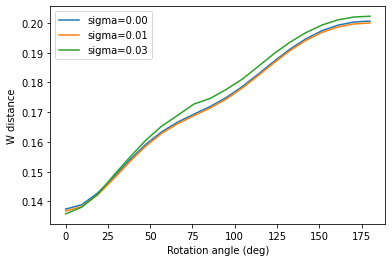

In [214]:
for sigma_idx, sigma in enumerate(sigmas[:-2]):
  sr = pd.Series(W[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Text(0, 0.5, 'W distance')

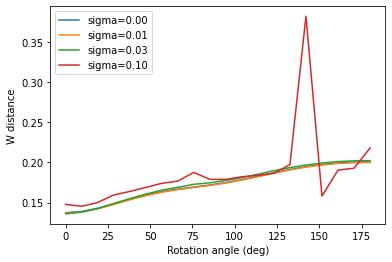

In [215]:
for sigma_idx, sigma in enumerate(sigmas[:-1]):
  sr = pd.Series(W[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Text(0, 0.5, 'W distance')

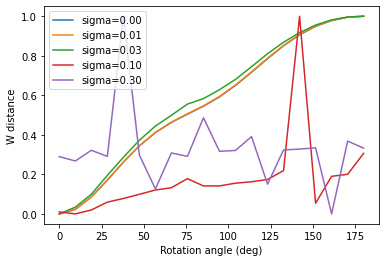

In [240]:
W_01 = rownorm_01(W)

for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(W_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

Now that we see that the W distance is more sensitive to noise, compared with the L2 distance.

Perhaps the regularization parameter can help this.

Let's look at a protein example now, which has all sorts of fine detail, compared with our gaussian blob toy example.